### Student Information
Name: 黃柏瑀

Student ID: 105062641

In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import plotly.plotly as py
import plotly.graph_objs as go
import math
from gensim.models import word2vec
 

# my functions
import helpers.data_mining_helpers as dmh
import helpers.text_analysis as ta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
semanticDF = pd.read_csv('./dataset/Sentiment_Labelled_Sentences_Data_Set.csv')

In [45]:
# Checkout if duplicated record
print("duplicated record: "+str(sum(semanticDF.duplicated(keep=False))))
print(semanticDF.shape)
#semanticDF[semanticDF.duplicated(keep=False)]

# Remove them
semanticDF = semanticDF.drop_duplicates()
print("duplicated record: "+str(sum(semanticDF.duplicated(keep=False))))
print(semanticDF.shape) 

# We can observe that 17 duplicated records been eliminated!

duplicated record: 34
(3000, 3)
duplicated record: 0
(2983, 3)


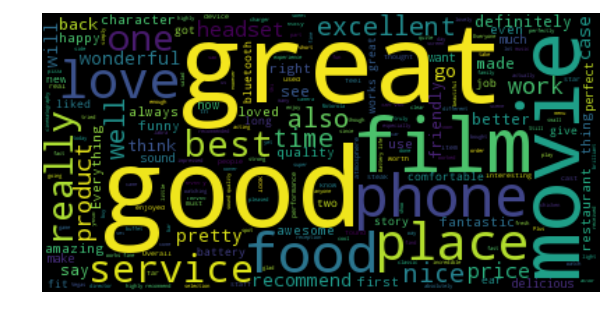

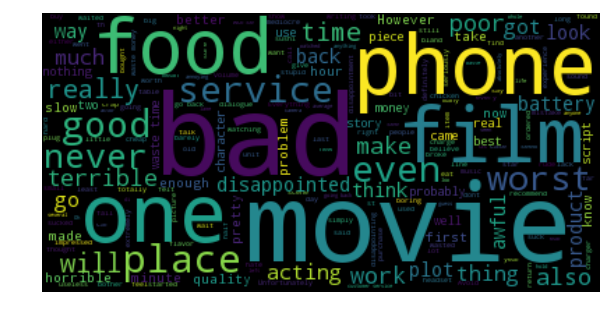

In [46]:
postive_sentence = (semanticDF['sentence'][semanticDF['label'] == 1])
negative_sentence = semanticDF['sentence'][semanticDF['label'] == 0]

ta.plot_word_cloud(postive_sentence.to_string())
ta.plot_word_cloud(negative_sentence.to_string())

In [47]:
from nltk.corpus import stopwords
stopWord = stopwords.words('english')
p_token = []
n_token = []

for sentence in postive_sentence:
    p_token += dmh.tokenize_text(sentence.lower())
    
for sentence in negative_sentence:
    n_token += dmh.tokenize_text(sentence.lower())

# Remove stop word
p_token = [x for x in p_token if x not in stopWord ]
n_token = [x for x in n_token if x not in stopWord ]

# tag each token with 詞性
p_tagged = nltk.pos_tag(p_token)
n_tagged = nltk.pos_tag(n_token)

# Focus on only on "noun words"
p_nouns = [word for word,pos in p_tagged if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
n_nouns = [word for word,pos in n_tagged if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

p_token_dict = ta.get_tokens_and_frequency(p_nouns)
n_token_dict = ta.get_tokens_and_frequency(n_nouns)

In [53]:
#for key, value in p_token_dict.items():
#    print(key, value)
py.iplot(ta.plot_word_frequency([list(p_token_dict.keys())[0:30], list(p_token_dict.values())[0:30]], "Postive sentence's word freqency"))

In [52]:
py.iplot(ta.plot_word_frequency([list(n_token_dict.keys())[0:30], list(n_token_dict.values())[0:30]], "Negative sentence's word freqency"))

---

### Instructions

- Download the dataset provided in this [link](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#). The sentiment dataset contains a `sentence` and `score` label. Read what the dataset is about on the link provided before you start exploring it. 


- Then, you are asked to apply each of the data exploration and data operation techniques learned in the [first lab session](https://goo.gl/Sg4FS1) on the new dataset. You don't need to explain all the procedures as we did in the notebook, but you are expected to provide some **minimal comments** explaining your code. You are also expected to use the same libraries used in the first lab session. You are allowed to use and modify the `helper` functions we provided in the first lab session or create your own. Also, be aware that the helper functions may need modification as you are dealing with a completely different dataset. This part is worth 80% of your grade!


- After you have completed the operations, you should attempt the **bonus exercises** provided in the [notebook](https://goo.gl/Sg4FS1) we used for the first lab session. There are six (6) additional exercises; attempt them all, as it is part of your grade (10%). 


- You are also expected to tidy up your notebook and attempt new data operations that you have learned so far in the Data Mining course. Surprise us! This segment is worth 10% of your grade.


- After completing all the above tasks, you are free to remove this header block and submit your assignment following the guide provided in the `README.md` file of the assignment's [repository](https://github.com/omarsar/data_mining_hw_1). 